# Principal Component Analysis (PCA) and Clustering

We will group our gym members into clusters. The idea is to use these clusters to place gym members into groups of customers that exhibit similar behaviors. This will help us identify the patterns that influence whether customer decides to stay or leave.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from plotter import *

We will perform clustering on the training data. We will allocate 80% of the data set for training and the remaining 20% for testing.

In [2]:
df = pd.read_csv('gym_churn_us.csv')

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (3200, 13)
y_train.shape: (3200,)
X_test.shape: (800, 13)
y_test.shape: (800,)


We will observe how different normalization techniques and how the amount of principal components impacts the clusters of our data. We will test `MinMaxScaler()`, `StandardScaler()`, and `RobustScaler()` with two and three principal components. Given that most of the data is discrete and not normally distributed, we will expect `MinMaxScaler()` and `RobustScaler()` to perform better than `StandardScaler()`.

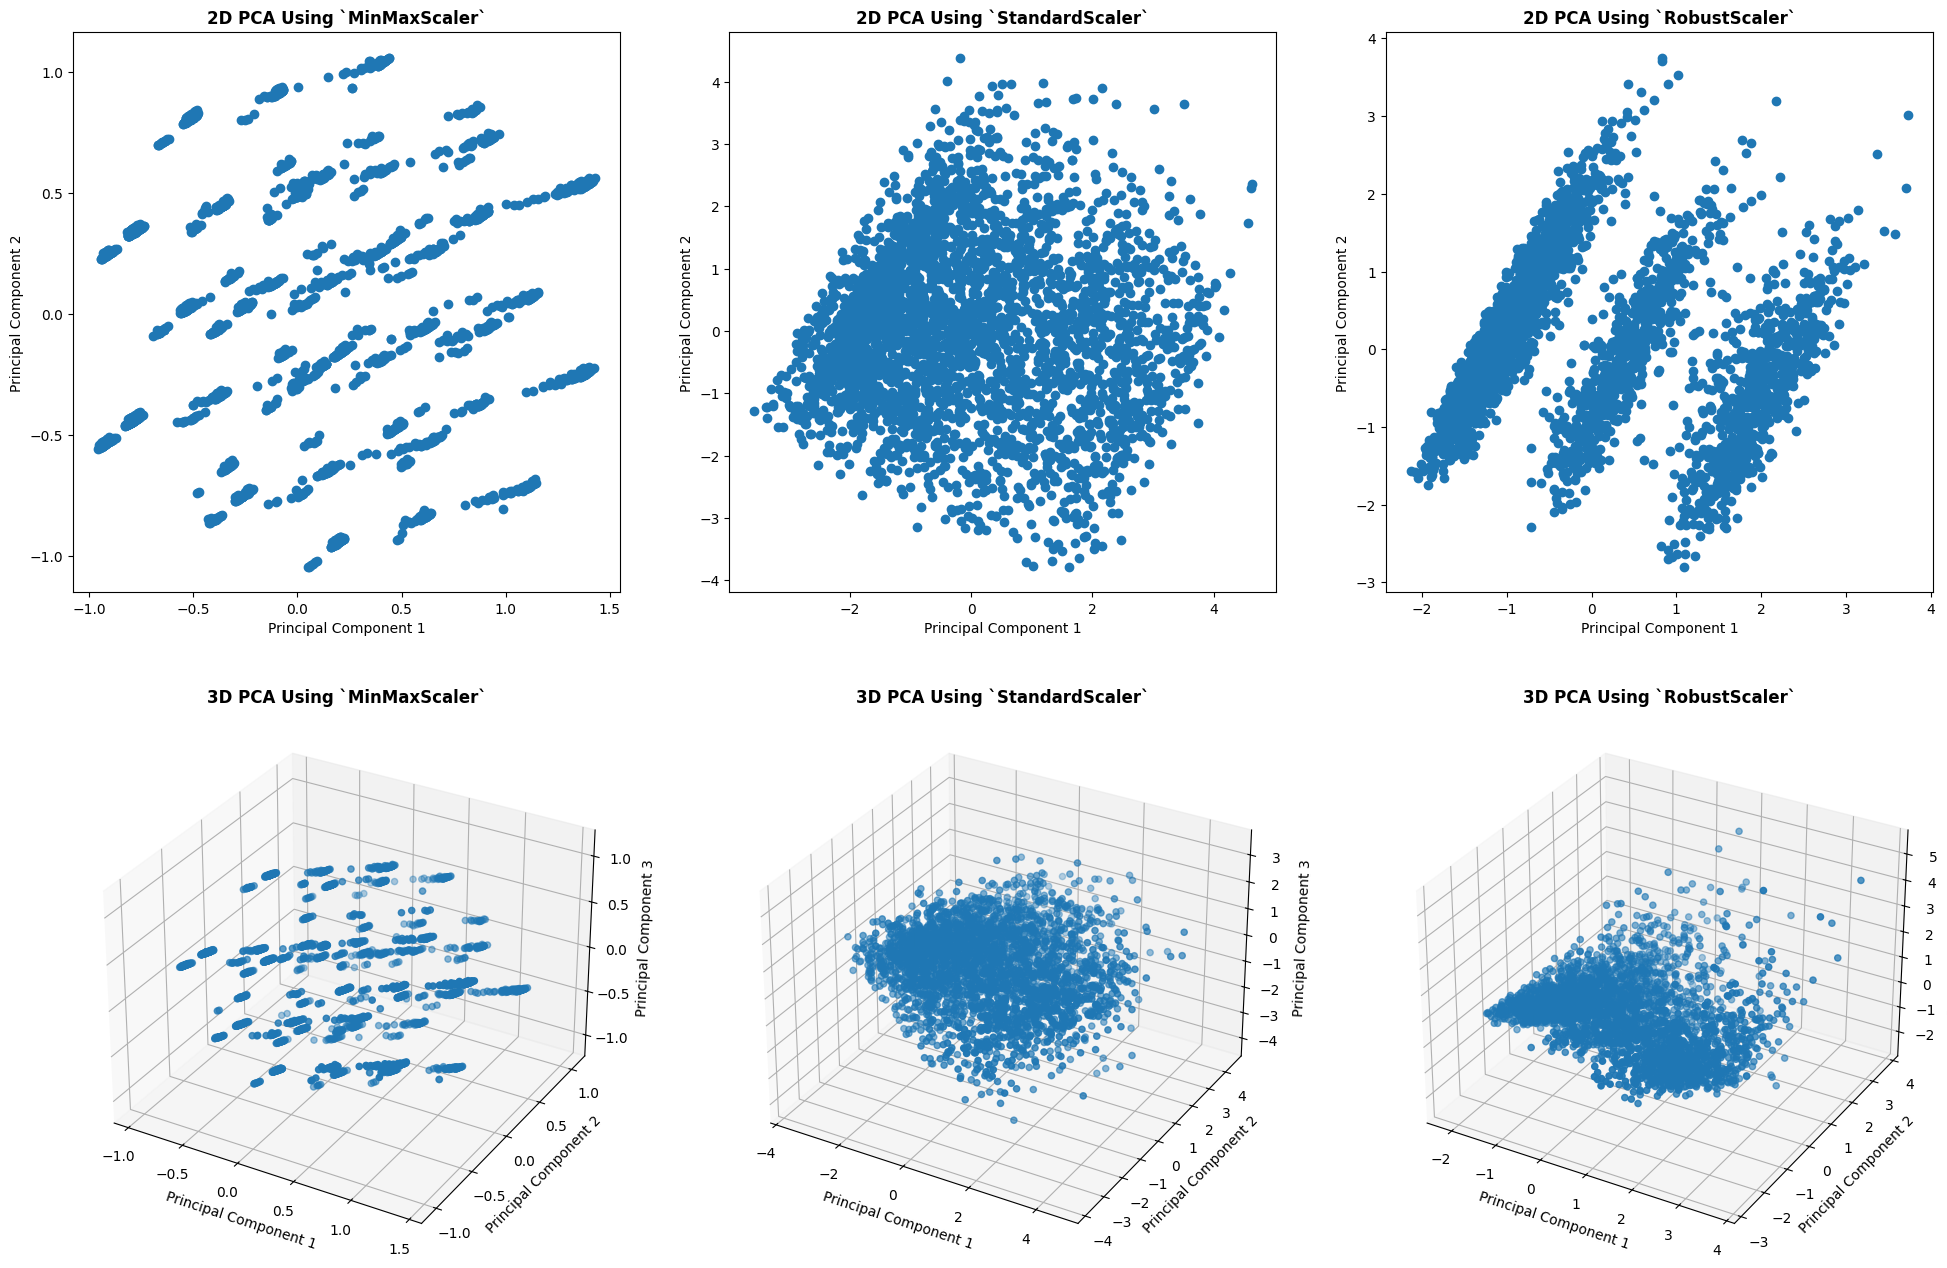

In [3]:
scalers = {'`MinMaxScaler`': MinMaxScaler(),
           '`StandardScaler`': StandardScaler(),
           '`RobustScaler`': RobustScaler()}


fig = plt.figure(figsize=(24,16))

for i, (key, value) in enumerate(scalers.items()):
    for n_components in range(2,4):
        scaler_name = key
        scaler = value

        projection = '3d' if n_components==3 else None
        ax = fig.add_subplot(2,3,(i+1)+(n_components-2)*3, projection=projection)

        X_norm = scaler.fit_transform(X_train)

        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_norm)
        ax.scatter(*X_pca.T)
        
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        if n_components == 3:
            ax.set_zlabel('Principal Component 3')
        
        ax.set_title(f'{n_components}D PCA Using {scaler_name}', fontweight='bold')

plt.show()

Using `RobustScaler()` with two principal components seems to generate the most distinct clusters. These clusers are elliptical in shape, so we must pick a clustering algorithm to account for this. 

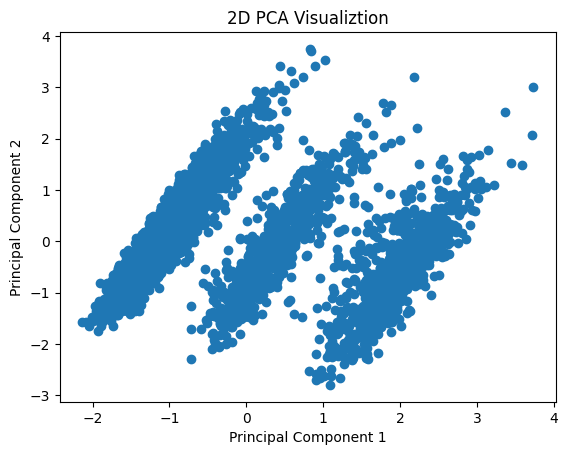

In [4]:
# perform PCA to reduce dimensionality of data for visualizations
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_norm)
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title('2D PCA Visualiztion')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [5]:
# Fit GMM with 3 components
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
labels = gmm.fit_predict(X_pca)  # X_pca: shape (n, 2)

# probabilities for soft clustering
probs = gmm.predict_proba(X_pca)

In [6]:
probs

array([[2.43485080e-83, 2.27068569e-14, 1.00000000e+00],
       [9.99999949e-01, 5.05516055e-08, 1.53655480e-24],
       [6.40225299e-88, 4.04625223e-15, 1.00000000e+00],
       ...,
       [1.00000000e+00, 7.07521892e-13, 1.42359345e-32],
       [1.00000000e+00, 3.33715611e-13, 1.01977121e-32],
       [2.76318762e-76, 5.47514234e-12, 1.00000000e+00]], shape=(3200, 3))

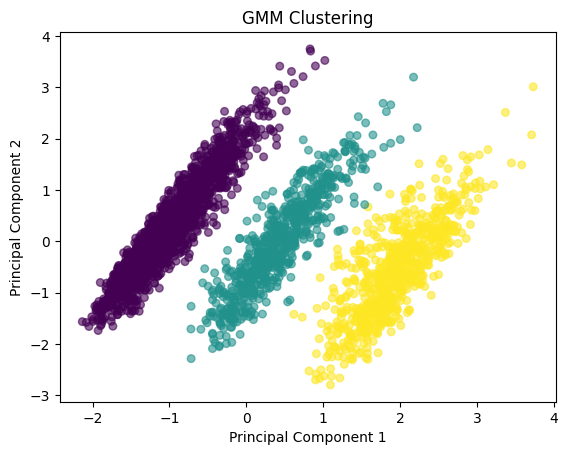

In [7]:
# plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
plt.title("GMM Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Using our best estimate of each individual's cluster, we can examine the overall behaviors of each group.

In [8]:
train_data_hard_clusters = df.copy().iloc[X_train.index]
train_data_hard_clusters['Cluster'] = labels
train_data_hard_clusters.groupby('Cluster').mean().T

Cluster,0,1,2
gender,0.498577,0.523256,0.513907
Near_Location,0.810472,0.863372,0.936424
Partner,0.348890,0.569767,0.721854
Promo_friends,0.212863,0.376453,0.490066
Phone,0.909505,0.902616,0.913907
Contract_period,1.000000,6.130814,12.000000
Group_visits,0.344337,0.449128,0.561589
Age,28.729084,29.425872,29.770861
Avg_additional_charges_total,138.295965,149.710346,165.677338
Month_to_end_contract,1.000000,5.565407,10.965563


In [9]:
quantitative_features = []
binary_features = []
for col in df.columns:
    if col != 'Churn':
        if len(df[col].unique()) > 2:
            quantitative_features.append(col)
        else:
            binary_features.append(col)
print(quantitative_features)
print(binary_features)

['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']
['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']


In [10]:
on_proportion = train_data_hard_clusters.groupby('Cluster')[binary_features+['Churn']].mean()
on_proportion

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Churn
Cluster,,,,,,,
0,0.498577,0.810472,0.348890,0.212863,0.909505,0.344337,0.428002
1,0.523256,0.863372,0.569767,0.376453,0.902616,0.449128,0.132267
2,0.513907,0.936424,0.721854,0.490066,0.913907,0.561589,0.026490


In [11]:
off_proportion = 1-on_proportion
off_proportion

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Churn
Cluster,,,,,,,
0,0.501423,0.189528,0.651110,0.787137,0.090495,0.655663,0.571998
1,0.476744,0.136628,0.430233,0.623547,0.097384,0.550872,0.867733
2,0.486093,0.063576,0.278146,0.509934,0.086093,0.438411,0.973510


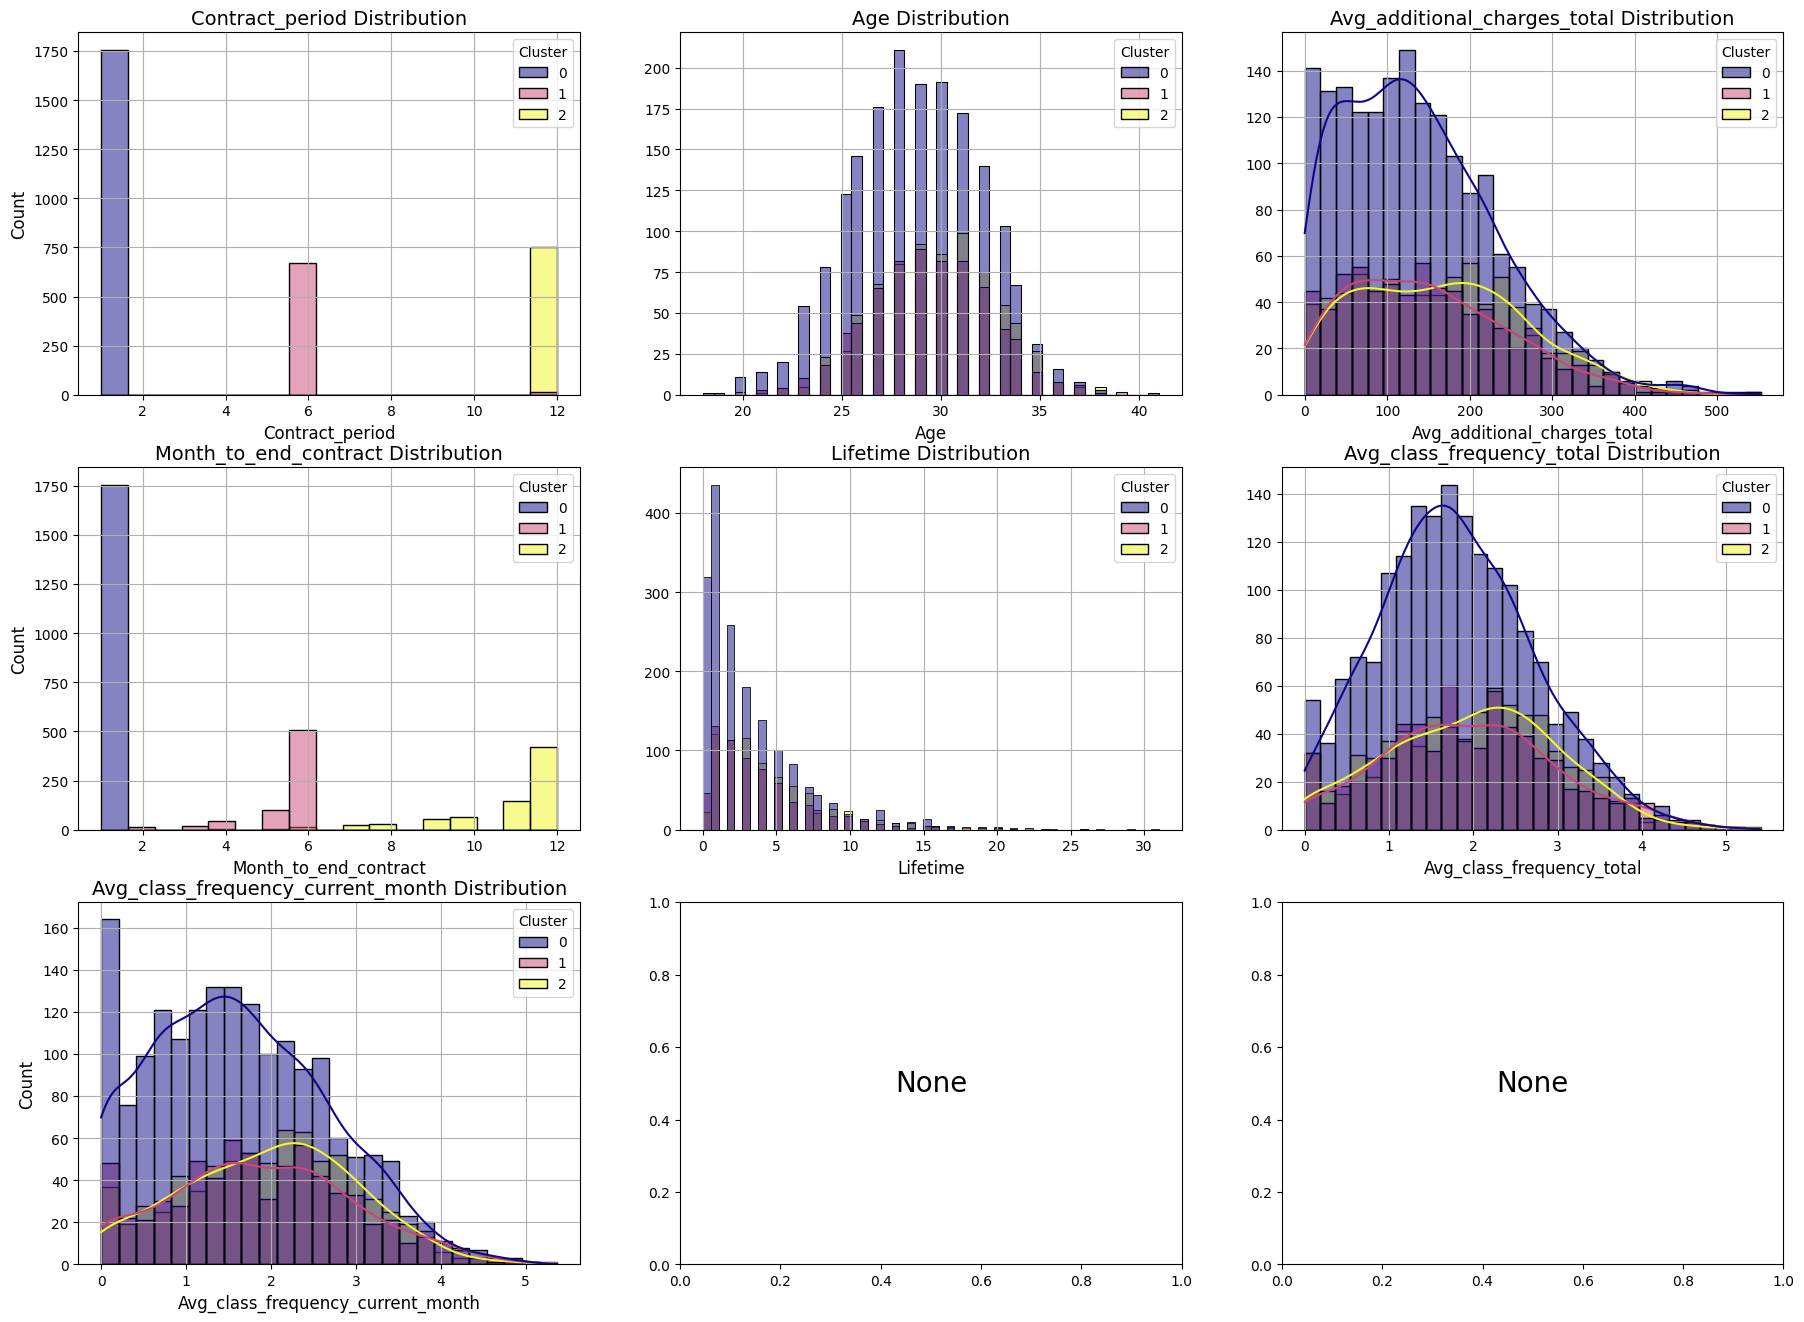

In [12]:
fig, ax = plot_hist(train_data_hard_clusters[quantitative_features+['Cluster']], hue='Cluster', palette='plasma', figsize=(22,16))
plt.show()

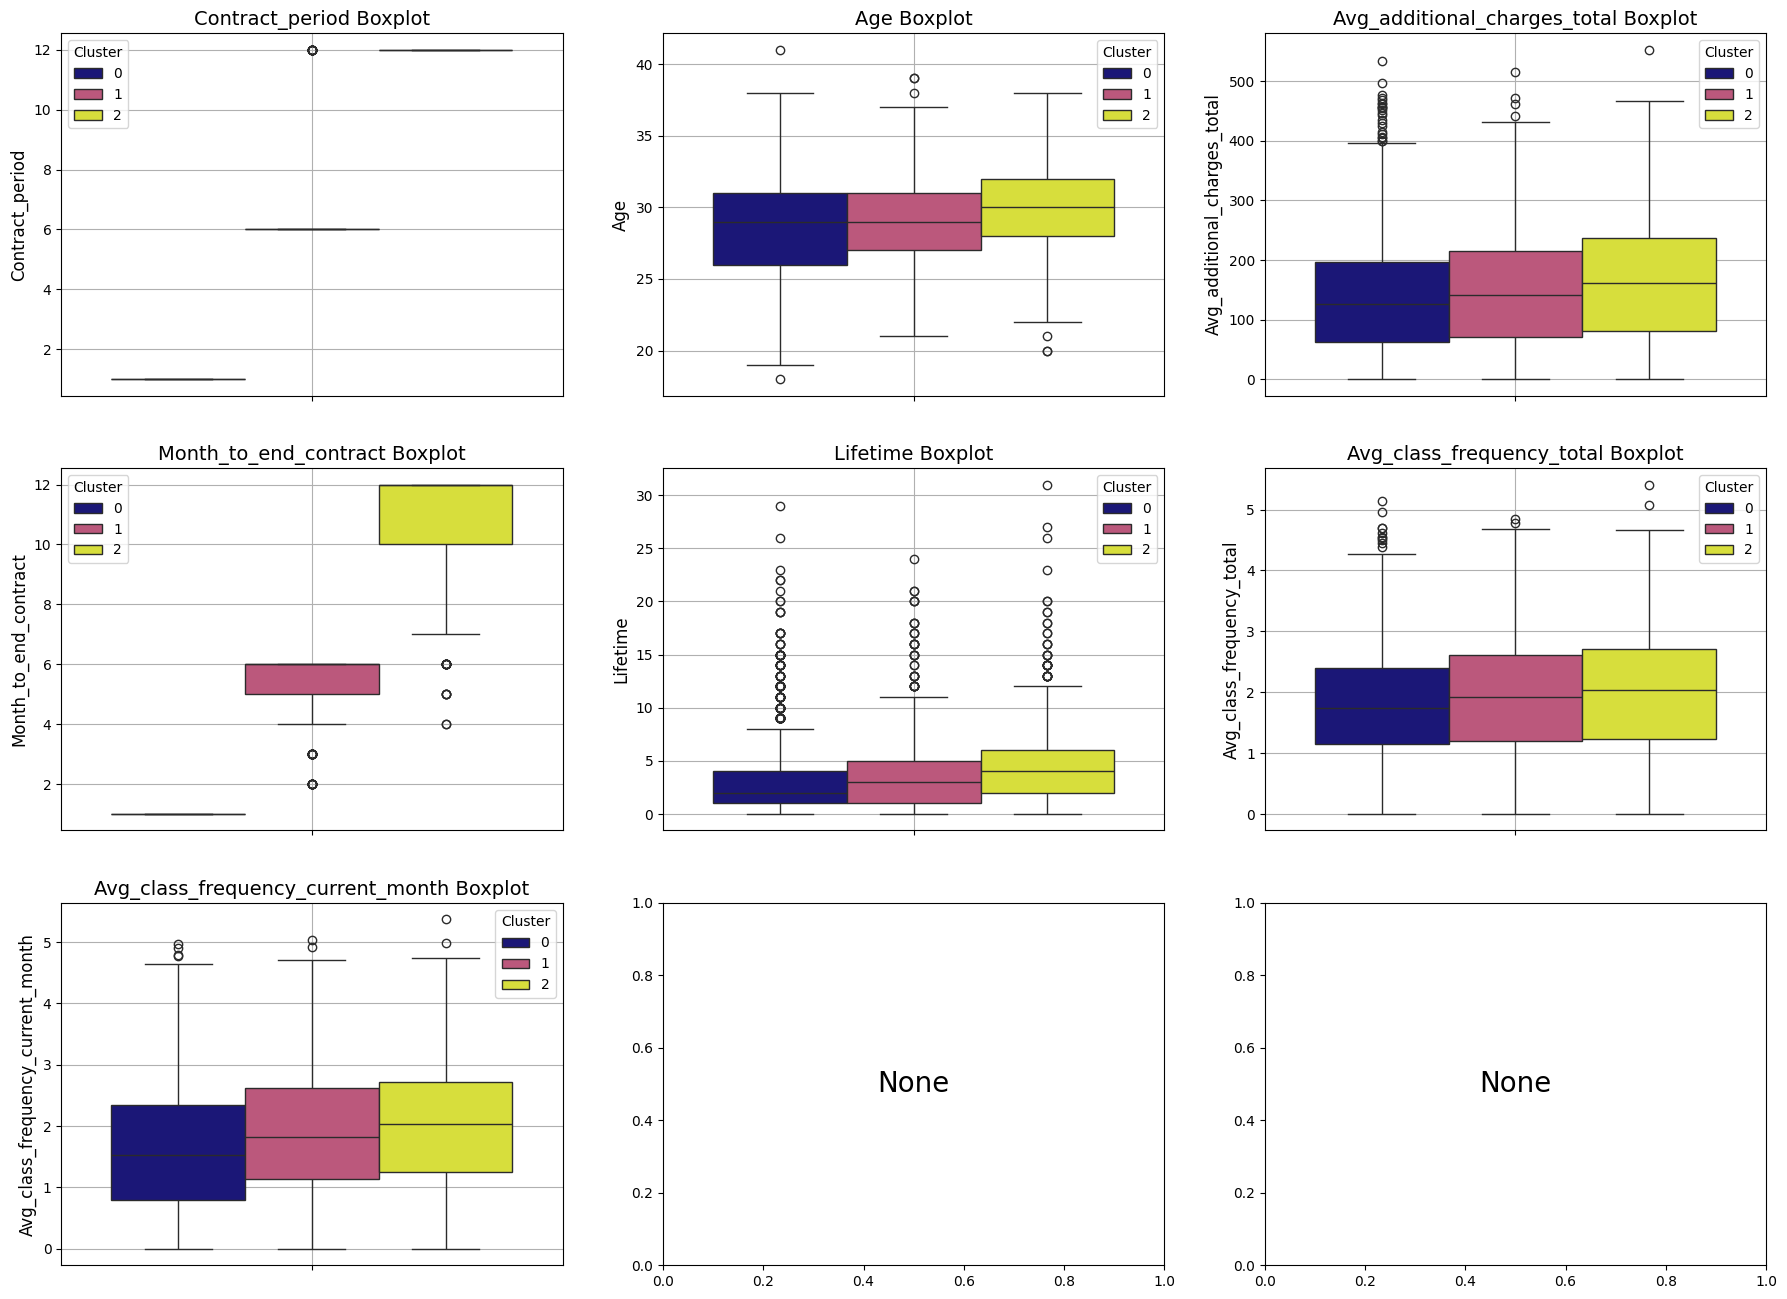

In [13]:
fig, ax = plot_box(train_data_hard_clusters[quantitative_features+['Cluster']], hue='Cluster', palette='plasma', figsize=(22,16))
plt.show()

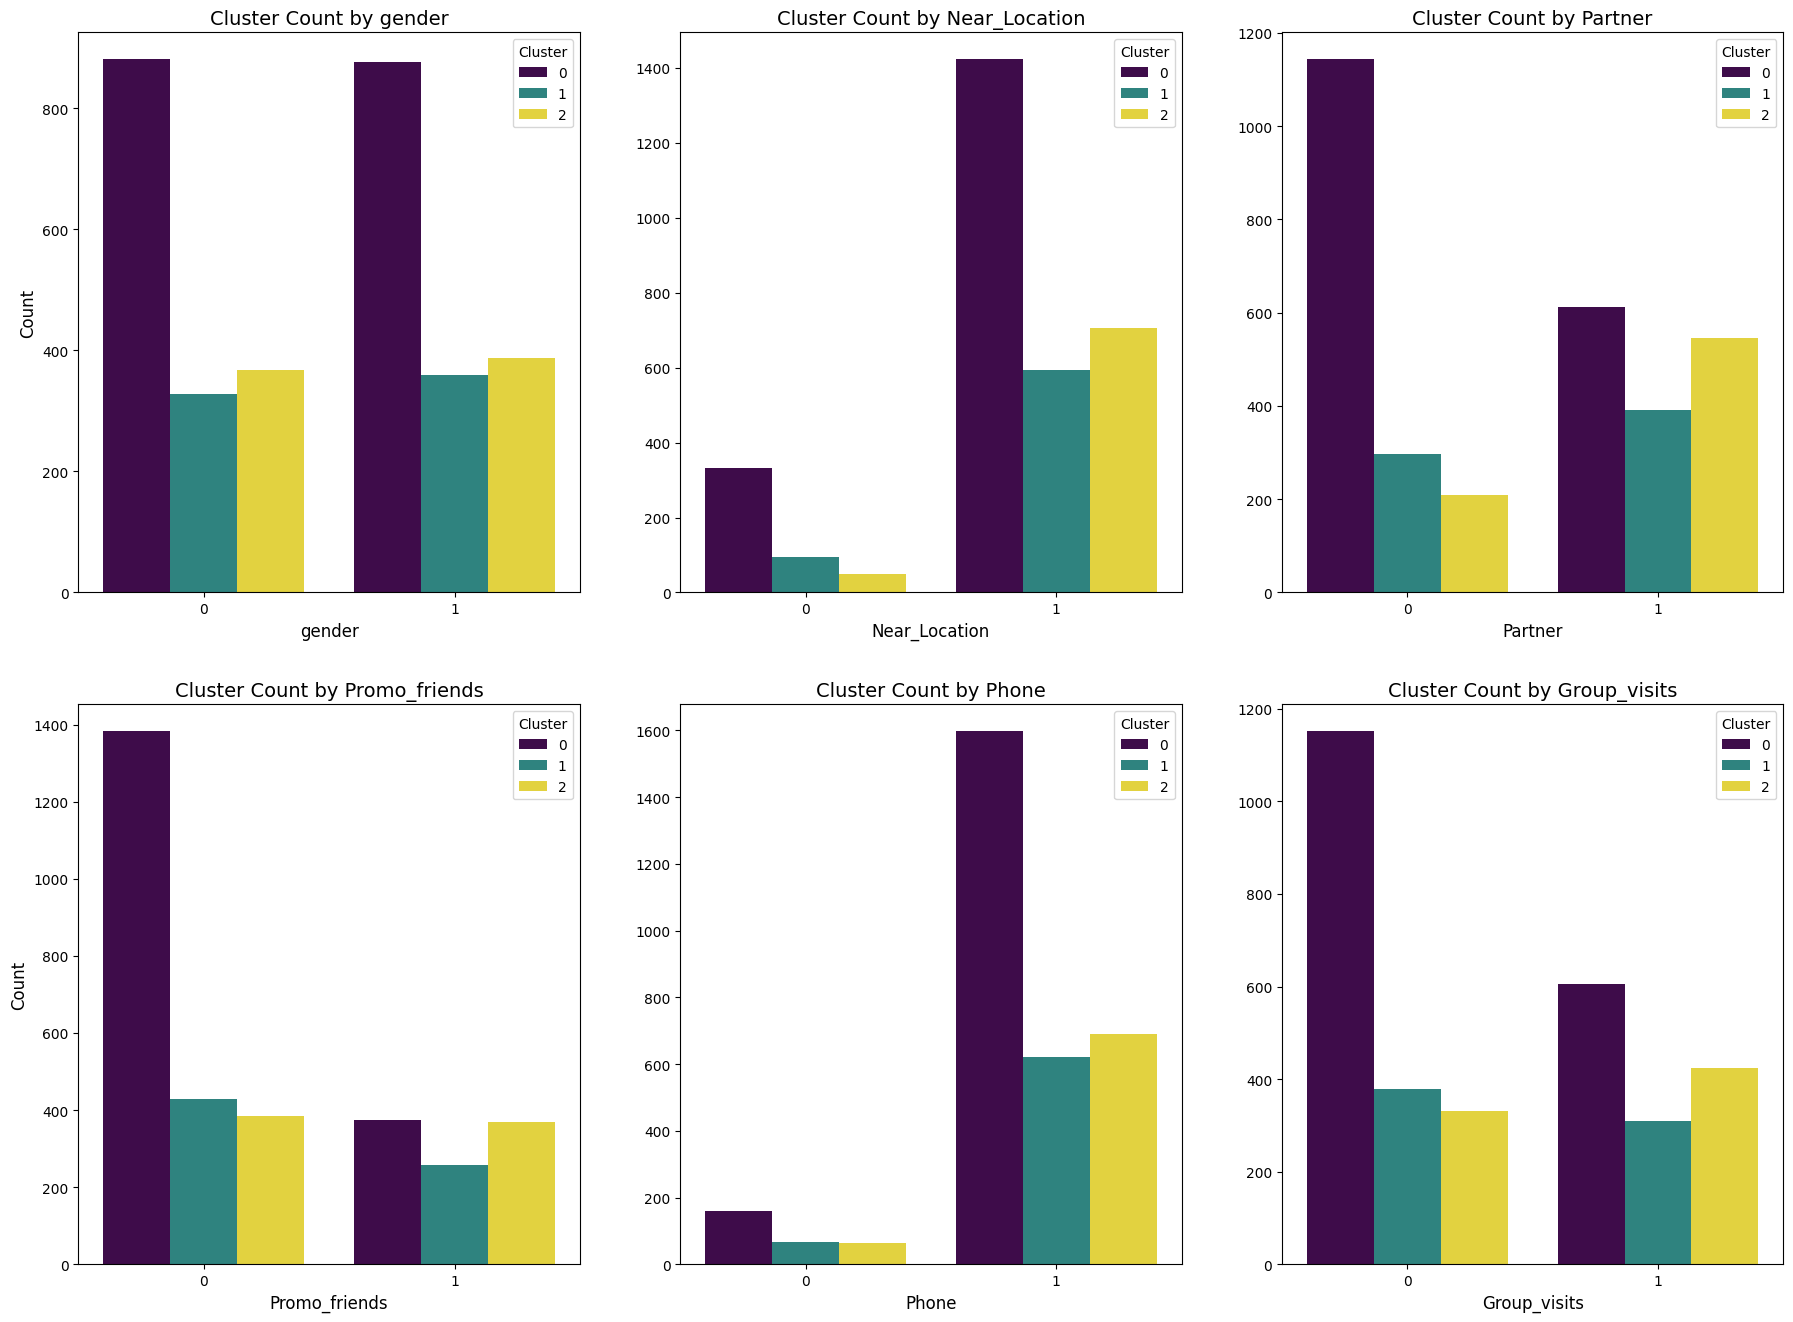

In [14]:
fig, ax = plot_bar(train_data_hard_clusters[binary_features+['Cluster']], hue='Cluster', palette='viridis', figsize=(22,16))
plt.show()

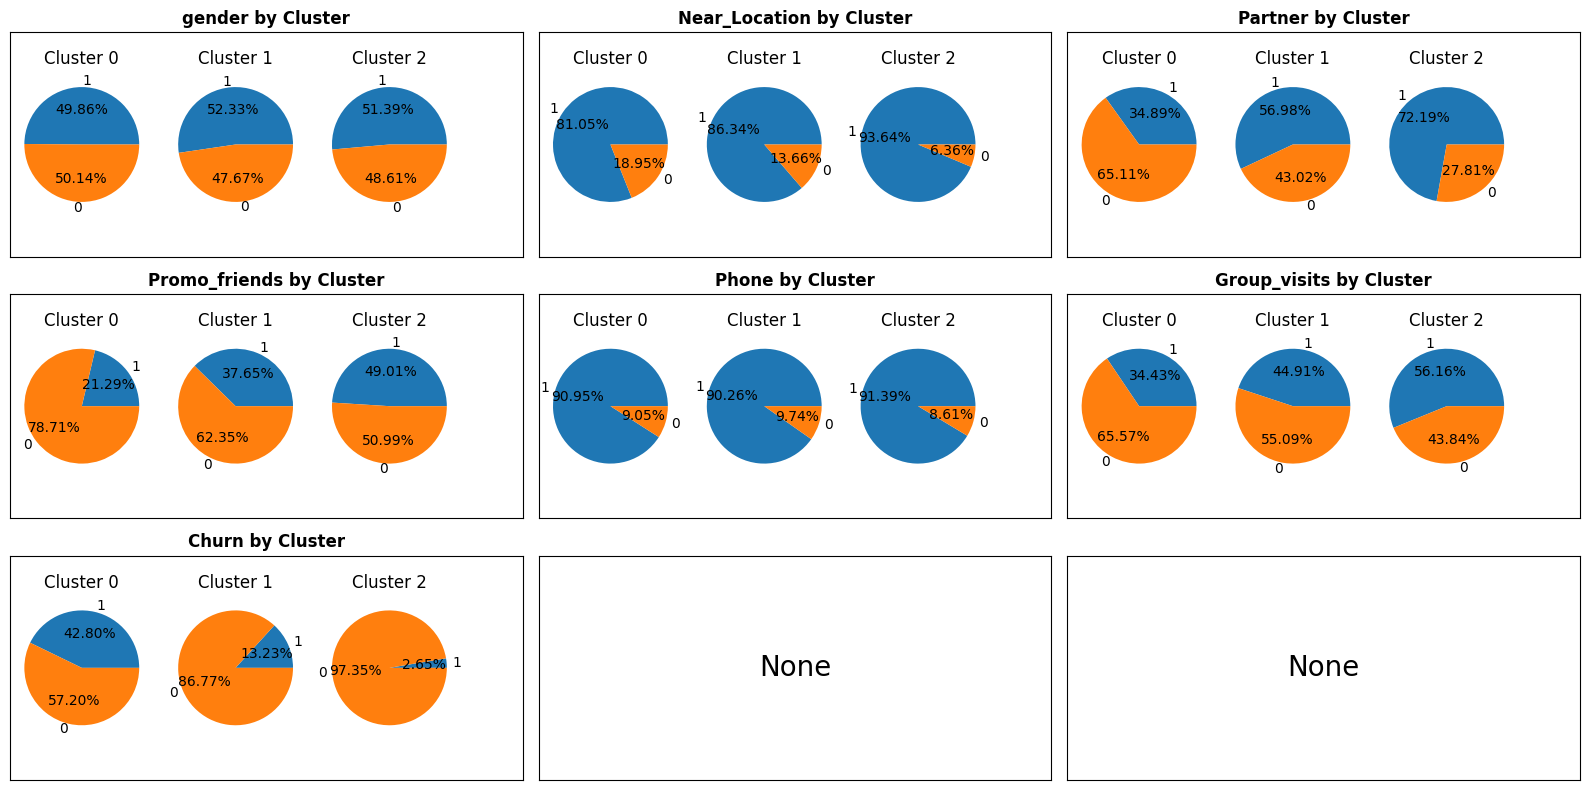

In [15]:
plot_pie(train_data_hard_clusters[binary_features+['Churn', 'Cluster']], figsize=(16,8), n_clusters=3)
plt.show()

In [16]:
train_data_soft_clusters = df.copy().iloc[X_train.index]
train_data_soft_clusters[[f'cluster_{i}_prob' for i in range(3)]] = np.round(probs, 2)

train_data_soft_clusters

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_0_prob,cluster_1_prob,cluster_2_prob
1161,0,1,1,1,1,12,0,31,183.340029,11.0,8,3.590505,3.473680,0,0.0,0.0,1.0
2355,0,1,0,0,1,1,0,30,40.559417,1.0,26,1.663034,1.750301,0,1.0,0.0,0.0
1831,1,1,1,0,1,12,0,27,32.123604,12.0,5,1.060272,0.913766,0,0.0,0.0,1.0
156,0,1,1,1,1,6,0,26,54.694211,6.0,9,2.531159,2.446842,0,0.0,1.0,0.0
195,0,1,0,0,0,1,0,29,241.701674,1.0,4,1.690380,1.595065,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0,0,0,0,0,1,0,31,139.665457,1.0,3,2.104185,2.144784,0,1.0,0.0,0.0
3264,1,1,1,1,0,12,1,34,232.148448,10.0,9,1.330589,1.273503,0,0.0,0.0,1.0
1653,0,1,0,0,1,1,0,25,179.043886,1.0,3,1.128035,1.155351,0,1.0,0.0,0.0
2607,1,1,0,0,1,1,1,28,7.614528,1.0,2,1.920819,1.737227,1,1.0,0.0,0.0


In [17]:
train_data_soft_clusters[train_data_soft_clusters['cluster_0_prob']<0.95][train_data_soft_clusters[train_data_soft_clusters['cluster_0_prob']<=0.95]['cluster_0_prob']>0.05]

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_0_prob,cluster_1_prob,cluster_2_prob


We are vary confident about the predictions made for cluster 0. Members either have less than 5\% or more than 95\% likelihood of being a part of this cluster.

In [18]:
train_data_soft_clusters[train_data_soft_clusters['cluster_1_prob']<=0.95][train_data_soft_clusters[train_data_soft_clusters['cluster_1_prob']<=0.95]['cluster_1_prob']>=0.05].drop('cluster_0_prob', axis=1)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_1_prob,cluster_2_prob
1013,1,1,1,1,1,12,1,20,100.198007,5.0,5,2.213092,2.345301,0,0.12,0.88
1751,0,1,1,0,1,12,0,28,232.990908,4.0,14,3.964821,3.957143,0,0.84,0.16
1520,1,1,1,0,1,12,1,30,105.422645,5.0,2,2.561457,2.603602,0,0.27,0.73
1340,1,1,1,0,1,12,1,34,24.923561,5.0,3,3.791391,3.846170,0,0.62,0.38
1132,1,1,0,0,1,12,0,31,93.456776,6.0,8,2.683690,2.552564,0,0.24,0.76
2442,1,1,0,0,1,12,0,27,232.658376,6.0,2,0.936082,0.993956,0,0.14,0.86
1365,0,1,1,1,1,12,0,29,50.864460,5.0,1,3.527583,3.473861,0,0.85,0.15
604,0,1,1,1,1,12,0,33,209.586263,4.0,3,1.857879,1.902694,0,0.06,0.94
2995,0,1,0,0,1,12,0,34,11.127884,6.0,1,3.018789,2.848794,0,0.95,0.05
2897,1,1,1,1,1,12,1,31,16.439138,3.0,9,2.481678,2.443623,0,0.65,0.35


In [19]:
train_data_soft_clusters[train_data_soft_clusters['cluster_2_prob']<=0.95][train_data_soft_clusters[train_data_soft_clusters['cluster_2_prob']<=0.95]['cluster_2_prob']>=0.05]

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_0_prob,cluster_1_prob,cluster_2_prob
1013,1,1,1,1,1,12,1,20,100.198007,5.0,5,2.213092,2.345301,0,0.0,0.12,0.88
1751,0,1,1,0,1,12,0,28,232.990908,4.0,14,3.964821,3.957143,0,0.0,0.84,0.16
1520,1,1,1,0,1,12,1,30,105.422645,5.0,2,2.561457,2.603602,0,0.0,0.27,0.73
1340,1,1,1,0,1,12,1,34,24.923561,5.0,3,3.791391,3.846170,0,0.0,0.62,0.38
1132,1,1,0,0,1,12,0,31,93.456776,6.0,8,2.683690,2.552564,0,0.0,0.24,0.76
2442,1,1,0,0,1,12,0,27,232.658376,6.0,2,0.936082,0.993956,0,0.0,0.14,0.86
1365,0,1,1,1,1,12,0,29,50.864460,5.0,1,3.527583,3.473861,0,0.0,0.85,0.15
604,0,1,1,1,1,12,0,33,209.586263,4.0,3,1.857879,1.902694,0,0.0,0.06,0.94
2995,0,1,0,0,1,12,0,34,11.127884,6.0,1,3.018789,2.848794,0,0.0,0.95,0.05
2897,1,1,1,1,1,12,1,31,16.439138,3.0,9,2.481678,2.443623,0,0.0,0.65,0.35


In [20]:
print(train_data_soft_clusters['cluster_0_prob'].between(0.05, 0.95).sum())
print(train_data_soft_clusters['cluster_1_prob'].between(0.05, 0.95).sum())
print(train_data_soft_clusters['cluster_2_prob'].between(0.05, 0.95).sum())

0
10
10


In [21]:
for n in range(probs.shape[1]):
    for i in range(len(probs[:,n])):
        prob = probs[i,n]
        if prob > 0.05 and prob < 0.95:
            print(f'Member {train_data_soft_clusters.index[i]} has {prob*100:.2f}% likelihood of being in cluster {n}')

Member 1013 has 11.73% likelihood of being in cluster 1
Member 1751 has 83.67% likelihood of being in cluster 1
Member 1520 has 27.32% likelihood of being in cluster 1
Member 1340 has 62.36% likelihood of being in cluster 1
Member 1132 has 23.66% likelihood of being in cluster 1
Member 2442 has 13.55% likelihood of being in cluster 1
Member 1365 has 84.77% likelihood of being in cluster 1
Member 604 has 5.52% likelihood of being in cluster 1
Member 2995 has 94.69% likelihood of being in cluster 1
Member 2897 has 65.35% likelihood of being in cluster 1
Member 1013 has 88.27% likelihood of being in cluster 2
Member 1751 has 16.33% likelihood of being in cluster 2
Member 1520 has 72.68% likelihood of being in cluster 2
Member 1340 has 37.64% likelihood of being in cluster 2
Member 1132 has 76.34% likelihood of being in cluster 2
Member 2442 has 86.45% likelihood of being in cluster 2
Member 1365 has 15.23% likelihood of being in cluster 2
Member 604 has 94.48% likelihood of being in clust